In [21]:
from IPython import get_ipython


In [22]:
# オブジェクト指向のパーセプトロンAPI

import numpy as np

class Perceptron(object):
    """
    params
    --------------------
    eta: float - learning-rate
    n_iter: int - training iterator
    random_state: int - seed

    属性
    ーーーーーーーーーーーーーーーーーー
    w_: 1次元配列
    errors_: list 
        各エポックでの誤分類の数
    """

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        """
        params
        X: {配列のような構造データ}, shape= [ n_samples, n_features]
        Y: shape=[n_samples]
        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                # 重みwの更新
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update * 1
                # 重みの更新が0でない場合は誤分類としてカウント
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self
    
    def net_input(self, X):
        """ 総入力を計算"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)



In [23]:
# Irisデータセットでのパーセプトロンモデルのトレーニング
import pandas as pd
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                    'machine-learning-databases/iris/iris.data', header=None)
df.tail()



,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


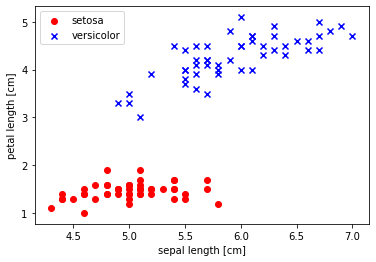

In [24]:
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import numpy as np

# 目的変数の抽出
y = df.iloc[0:100, 4].values
# ラベルの変更
y = np.where(y == 'Iris-setosa', -1 ,1)
# 1-100行目の1,3列目の抽出
X = df.iloc[0:100, [0, 2]].values
# setosaは赤丸
plt.scatter(X[:50,0], X[:50,1], color='red', marker='o', label='setosa')
plt.scatter(X[50:100,0], X[50:100,1], color='blue', marker='x', label='versicolor')
# 軸ラベルの設定
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()



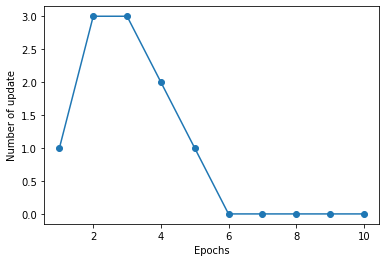

In [25]:
# let's train!
ppn = Perceptron(eta=0.1, n_iter=10)
ppn.fit(X, y)
# エポックと誤分類誤差の関係の折れ線グラフをプロット
plt.plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of update')
plt.show()



In [26]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # マーカーとカラーマップの準備
    markers = ('s', 'x', 'o', '^', 'v')
    color = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(color[:len(np.unique(y))])

    # 決定領域プロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() -1 , X[:, 1].max() + 1
    # グリッドポイントの生成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                            np.arange(x2_min, x2_max, resolution))
    # 各特徴量を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape)
    # グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # クラスごとにサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
                    y=X[y == cl, 1],
                    alpha=0.8,
                    c=color[idx],
                    marker=markers[idx],
                    label=cl,
                    edgecolors='black')



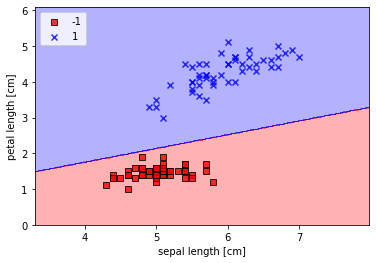

In [27]:
plot_decision_regions(X, y, classifier=ppn)
plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')
plt.show()



In [28]:
# ADALINEの実装
class AdalineGD(object):
    """ ADAptive LInear NEuron classifier

    params
    --------
    eta : float
        - Learning Rate
    n_iter : int
        - iteration
    random_state : int
        - seed

    Attribute
    --------
    w_ : 1次元配列
        - 適合後の重み
    cost_ : list
        - 各エポックでの誤差平方和のコスト関数
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        """ fit training data.

        params
        ----------
        X: shape = [n_samples, n_features]
        y: shape = [n_samples]

        return
        ----------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)

            # 恒等関数のため、直接 output = self.net_input(X)ともできた
            output = self.activation(net_input)

            # 誤差の計算
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            # w の更新
            self.w_[0] + self.eta * errors.sum()

            # コスト関数の計算
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """ 総入力を計算 """
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return X
    
    def predict(self, X):
        """ 1ステップ後のクラスラベルを返す """
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)



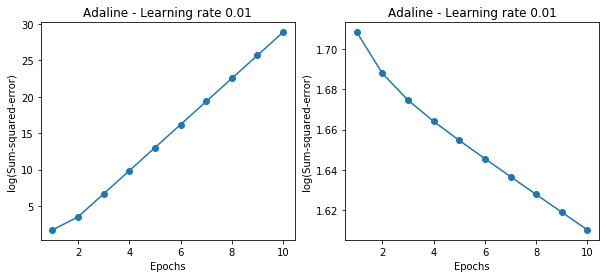

In [29]:
# 描画領域を1行2列に分割
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
# SGDによるADALINEの学習 (eta=0.01)
ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X, y)
# エポック数とコストの関係を表す折れ線グラフのプロット
ax[0].plot(range(1, len(ada1.cost_)+1), np.log10(ada1.cost_), marker='o')
# 軸ラベルの設定
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adaline - Learning rate 0.01')

# SGDによるADALINEの学習 (eta=0.0001)
ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X, y)
# エポック数とコストの関係を表す折れ線グラフのプロット
ax[1].plot(range(1, len(ada2.cost_)+1), np.log10(ada2.cost_), marker='o')
# 軸ラベルの設定
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('log(Sum-squared-error)')
ax[1].set_title('Adaline - Learning rate 0.01')

plt.show()


In [30]:
X_std = np.copy(X)

X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()



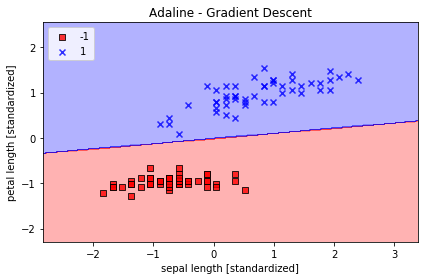

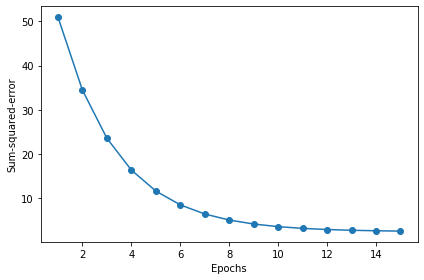

In [32]:
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)
# 境界領域のプロット
plot_decision_regions(X_std, y, classifier=ada)

# 設定
plt.title('Adaline - Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
# 図の表示
plt.tight_layout()
plt.show()

# エポック数とコストの関係を表す折れ線グラフのプロット
plt.plot(range(1, len(ada.cost_)+1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.tight_layout()
plt.show()


In [37]:
from numpy.random import seed
# ADALINEの実装
class AdalineSGD(object):
    """ ADAptive LInear NEuron classifier

    params
    --------
    eta : float
        - Learning Rate
    n_iter : int
        - iteration
    shuffle: bool
        - 循環を回避するためにエポックごとにシャッフル
    random_state : int
        - seed

    Attribute
    --------
    w_ : 1次元配列
        - 適合後の重み
    cost_ : list
        - 各エポックでの誤差平方和のコスト関数
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        """ fit training data.

        params
        ----------
        X: shape = [n_samples, n_features]
        y: shape = [n_samples]

        return
        ----------
        self : object

        """
        # 重みベクトルの生成
        self._initialize_weights(X.shape[1])
        self.cost_ = []

        # トレーニング回数分トレーニングデータを反復
        for i in range(self.n_iter):
            # 指定された場合はデータをシャッフル
            if self._shuffle:
                X, y = self._shuffle(X, y)

            # 各サンプルのコストを格納するリストの生成
            cost = []
            # 各サンプルに対応する計算
            for xi, target in zip(X, y):
                # 特徴量xiと目的変数yを用いた重みの更新とコストの計算
                cost.append(self._update_weights(xi, target))
            # サンプルの平均コストの計算
            avg_cost = sum(cost) / len(y)
            # 平均コストを格納
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        """ 重みを初期化させることなくトレーニングデータに適合させる """
        # 初期化されていない場合は初期化を実行
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        
        # 目的変数yの要素数が2以上の場合は
        # 各サンプルの特徴量xiと目的変数targetで重みを更新
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        # 目的変数の要素数が1の場合は
        # サンプル全体の特徴量Xと目的変数yで重みを更新
        else:
            self._update_weights(X, y)
        return self
    
    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """ 重みを小さな乱数に初期化 """
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1+m)
        self.w_initialized = True
    
    def _update_weights(self, xi, target):
        """ ADALINEの学習規則を用いて重みを更新 """
        output = self.activation(self.net_input(xi))
        # 誤差の計算
        error = (target - output)
        # 重みの更新
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        # コストの計算
        cost = 0.5 * error**2
        return cost
    
    def net_input(self, X):
        """ 総入力を計算 """
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        return X
    
    def predict(self, X):
        """ 1ステップ後のクラスラベルを返す """
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)


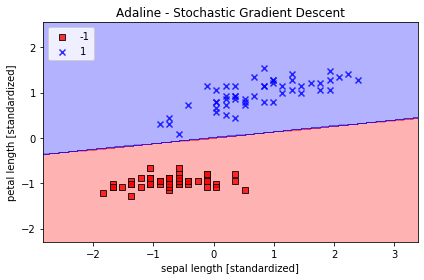

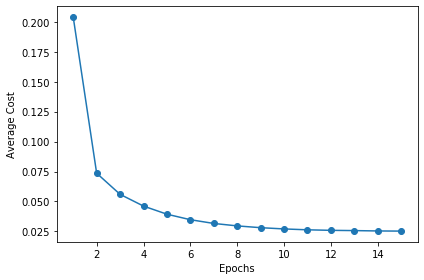

In [38]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
# 設定
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
# 図の表示
plt.tight_layout()
plt.show()

# エポック数とコストの関係を表す折れ線グラフのプロット
plt.plot(range(1, len(ada.cost_)+1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.tight_layout()
plt.show()

